---
title: "10.X Case Study: Recommender Systems"
subject: Singular Value Decomposition Applications
subtitle: Collaborative Filtering with SVD
short_title: "10.X Recommender Systems"
authors:
  - name: Nikolai Matni
    affiliations:
      - Dept. of Electrical and Systems Engineering
      - University of Pennsylvania
    email: nmatni@seas.upenn.edu
license: CC-BY-4.0
keywords: nodes, edges, Kirchoff`s law
math:
  '\vv': '\mathbf{#1}'
  '\bm': '\begin{bmatrix}'
  '\em': '\end{bmatrix}'
  '\R': '\mathbb{R}'
---

Recommender systems have become a vital part of our digital lives, guiding us towards products, services, and content we might like. Generally speaking, recommender systems are algorithms designed to suggest relevant items to users. These systems are used in various domains such as e-commerce, streaming services, and social media. They enhance user experience by filtering vast amounts of information to deliver personalized content. There are two main categories of recommender systms:

* **Content-Based Filtering**: Content-based filtering recommends items to users by analyzing the features of items they have previously liked, matching similar items based on those attributes.
* **Collaborative Filtering**: Collaborative filtering recommends items to users by identifying patterns and similarities in user behavior and preferences, leveraging the collective data from multiple users to make personalized suggestions.

``` {image} content_based_filtering.webp
```
``` {image} collaborative_filtering.webp
```

The tools that we have learned in this class are used in the design of both types of recommender system. In this case study, we will focus on collaborative filtering, where the singular value decomposition plays a critical roll. To start off with, let's download a dataset consisting of movie ratings from various users.

In [1]:
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from tqdm import tqdm

data = tfds.load('movielens/100k-ratings')

We will now convert the dataset into a pandas  dataframe consisting only of the movie titles, the user rating, and the user ID. 

In [3]:
ratings_list = []
for i, example in enumerate(tfds.as_numpy(data['train'])):
    if i == 80000:
        break
    ratings_list.append(example)
    
# Convert the list to a pandas DataFrame
ratings_df = pd.DataFrame(ratings_list, columns=['movie_title', 'user_rating', 'user_id'])

2024-08-08 08:23:47.118471: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Let's check out the dataset and see what it entails. We can print out the first five entries of the dataframe using the command ratings_df.head()

In [4]:
ratings_df.head()

,movie_title,user_rating,user_id
0,"b""One Flew Over the Cuckoo's Nest (1975)""",4.0,b'138'
1,b'Strictly Ballroom (1992)',2.0,b'92'
2,"b'Very Brady Sequel, A (1996)'",4.0,b'301'
3,b'Pulp Fiction (1994)',4.0,b'60'
4,b'Scream 2 (1997)',3.0,b'197'


Our dataset now consists only of the movie titles, the user id, and the user rating. Below, we'll look at the number of unique movies, the number of users, the range of the ratings, and the total number of entries in our dataset.

In [6]:
print('Number of movies: ', ratings_df['movie_title'].nunique())
print('Number of users: ', ratings_df['user_id'].nunique())
print('Minimum rating: ', np.min(ratings_df['user_rating']), ' Maximum rating: ',  np.max(ratings_df['user_rating']))
print('Number of data points: ', len(ratings_df))

Number of movies:  1627
Number of users:  943
Minimum rating:  1.0  Maximum rating:  5.0
Number of data points:  80000


Since there are $80000$ datapoints, and $943$ users, it means that we have reviews for about $80$ movies per user on average. This means that on average there are over $1500$ movies that haven't been watched by any given user. Our goal is to help each user to select which of these movies to watch next! 

Our first step in doing so will be to arrange the dataset into a matrix, and the users are the rows, and the movies are the columns. For every movie that has been reviewed by a user, we will fill the corresponding entry in the matrix with the ratings given by the user. To construct this matrix, we will define two python dictionaries. One will map the title of the movie into an array index, while the other will map the user id to an array index. 

In [10]:
movie_dict = dict(zip(list(ratings_df['movie_title'].unique()), range(ratings_df['movie_title'].nunique())))
user_dict = dict(zip(list(ratings_df['user_id'].unique()), range(ratings_df['user_id'].nunique())))

Given these dictionaries, we will construct our matrix, called "ratings_matrix". All entries will be initialized to zero. Then we will iterate through the dataset, and for every (movie, user) pair for which we have a rating, we will add that rating to our matrix. 

In [25]:
ratings_matrix = np.zeros((ratings_df['user_id'].nunique(), ratings_df['movie_title'].nunique()))
for i, entry in ratings_df.iterrows():
    ratings_matrix[user_dict[entry[2]], movie_dict[entry[0]]] = entry[1]

print(ratings_matrix)

/var/folders/4_/_wdy2jwx40q500zgz9zr76dh0000gn/T/ipykernel_87465/1989417239.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ratings_matrix[user_dict[entry[2]], movie_dict[entry[0]]] = entry[1]


[[4. 0. 0. ... 0. 0. 0.]
 [0. 2. 2. ... 0. 0. 0.]
 [5. 0. 4. ... 0. 0. 0.]
 ...
 [0. 0. 4. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


As the minimum rating was $1.0$, all $0.0$ entries are correspond to (user, movie) pairs where no rating was available in our dataset. Our first step to recommend movies to users will be to *impute*, or fill in, the missing entries. 

Without additional assumptions about the data, the imputation of this data can be quite random. Therefore, the standard assumption imposed for collaborative recommender systems is the rankings matrix is of rank $k < \min\{\# \mathrm{Users}, \# \mathrm{Movies}\}$. 

```{image} ratings_svd.webp
:width: 800px
:align: center
```

This assumption suggests that if we apply an singular value decomposition to the ratings matrix, there will be relatively few large singular values. Therefore, using the patterns just in the data that is present in the ratings matrix, we may be able to guess values for entries that are missing. Generally, this problem is referred to as low-rank matrix completion. In this case study, we will take a rather simple approach consisting of three steps:

* Fill in the missing entries with some crude guess
* Take the singular value decomposition, and truncate all but $k$ singular values.
* Construct an estimate for the ratings matrix using the truncated singular vectors and values.

There are many ways to fill in the missing entries. One option would be to assign the missing entries to have the average rating over all of the entries that are present. Another option would be to assume that users give fairly similar ratings to all movies, and assign missing entries in each row with the average of the existing entries in each row. Alternatively, we could assume that good movies are appreciated by all users, and assign missing entries in each column with the average of the existing entries in the column. We will stick with the last option for the remainder of this case study, but you are encouraged to try the other possibilities and see how the results change if you are curious!

Let's see what this matrix looks like below. 

In [26]:
for i in range(ratings_matrix.shape[1]):
    ratings_matrix[:,i][ratings_matrix[:,i] < 1.0] = np.mean(ratings_matrix[:,i][ratings_matrix[:,i] >= 1.0])

print(ratings_matrix)

[[4.         4.0617284  2.37681159 ... 1.         1.         1.        ]
 [4.23474178 2.         2.         ... 1.         1.         1.        ]
 [5.         4.0617284  4.         ... 1.         1.         1.        ]
 ...
 [4.23474178 4.0617284  4.         ... 1.         1.         1.        ]
 [4.23474178 4.0617284  2.37681159 ... 1.         1.         1.        ]
 [4.23474178 4.0617284  2.37681159 ... 1.         1.         1.        ]]


We now see that there are no longer zero entries in the ratings matrix. All missing values have been imputed with a crude guess. Let's now move on to the second step: taking the SVD of the ratings matrix. 

In [27]:
U, Sigma, Vt = np.linalg.svd(ratings_matrix, full_matrices=False)
print('recovery error: ', np.max(np.abs(ratings_matrix - U@np.diag(Sigma)@Vt)))

recovery error:  2.134292742539401e-12


Let's see how the singular values decay by plotting them on a log scale. 

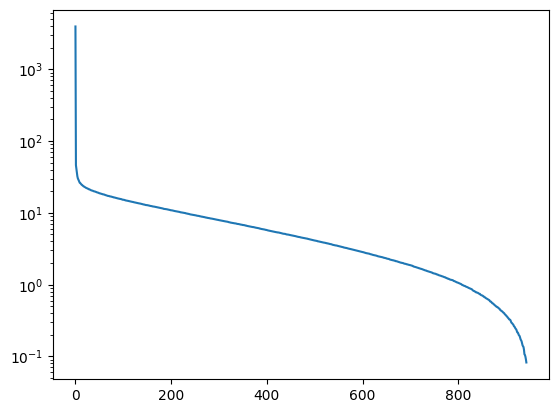

In [28]:
import matplotlib.pyplot as plt
plt.plot(Sigma)
plt.yscale('log')

The entries quickly decay in importance after about the first hundred. Let's try keeping $100$ singular values for the reconstruction.

In [40]:
r = 100
reconstruction = U[:,:r]@np.diag(Sigma[:r])@Vt[:r]

In [41]:
print(reconstruction)

[[4.30188457 4.0090725  2.38765634 ... 1.00137405 1.00137405 1.00137405]
 [4.12879791 3.40236143 2.03622834 ... 0.99963559 0.99963559 0.99963559]
 [4.78020309 4.04954832 3.49195111 ... 0.9983499  0.9983499  0.9983499 ]
 ...
 [4.07071835 4.0316504  2.49982589 ... 1.00136601 1.00136601 1.00136601]
 [4.30863531 4.09684949 2.43570969 ... 0.99893943 0.99893943 0.99893943]
 [4.10838972 4.04962656 2.36482362 ... 1.00232516 1.00232516 1.00232516]]


The result looks quite similar to the crudely imputed matrix from earlier, but with some small deviations. Let's use the result to recommend movies to a user. To start, we'll examine the hisotry of ratings by user zero. 

In [42]:
user = ratings_df['user_id'][0]
user_history = ratings_df.loc[ratings_df['user_id']==user]
print(user_history)

                                             movie_title  user_rating user_id
0              b"One Flew Over the Cuckoo's Nest (1975)"          4.0  b'138'
4515        b'Butch Cassidy and the Sundance Kid (1969)'          5.0  b'138'
5177                                     b'Giant (1956)'          4.0  b'138'
5264                          b'Mighty Aphrodite (1995)'          4.0  b'138'
10557                       b'This Is Spinal Tap (1984)'          4.0  b'138'
13204                                   b'Psycho (1960)'          4.0  b'138'
19632                       b'Gone with the Wind (1939)'          4.0  b'138'
22277  b'Dr. Strangelove or: How I Learned to Stop Wo...          5.0  b'138'
24479                        b'Cold Comfort Farm (1995)'          2.0  b'138'
25339                               b'Casablanca (1942)'          5.0  b'138'
30185        b'Treasure of the Sierra Madre, The (1948)'          5.0  b'138'
30400                   b'Brothers McMullen, The (1995)'        

Now let's look what our recommender system suggests. To recover the recommendations, we first make a python dictionary mapping the movie index back into the movie name. 

In [43]:
movie_dict_reversed = dict(zip(range(ratings_df['movie_title'].nunique()), list(ratings_df['movie_title'].unique())))

The recommendations we make to the user will now be the entries in the user's row of the reconstruction matrix with the highest score. Let's print out $20$ recommendations for user zero below. Along with each recommendation, we'll check whether the user has already watched that movie. 

In [44]:
best_movies = np.argsort(reconstruction[user_dict[user]])[-20:]
for movie in best_movies:
    print('Movie suggestion: ', movie_dict_reversed[movie], 'already watched? : ', movie_dict_reversed[movie] in list(user_history['movie_title']))

Movie suggestion:  b'Wallace & Gromit: The Best of Aardman Animation (1996)' already watched? :  False
Movie suggestion:  b'Close Shave, A (1995)' already watched? :  False
Movie suggestion:  b'Silence of the Lambs, The (1991)' already watched? :  True
Movie suggestion:  b'World of Apu, The (Apur Sansar) (1959)' already watched? :  False
Movie suggestion:  b'Pather Panchali (1955)' already watched? :  False
Movie suggestion:  b'Pulp Fiction (1994)' already watched? :  True
Movie suggestion:  b'Marlene Dietrich: Shadow and Light (1996) ' already watched? :  False
Movie suggestion:  b'Saint of Fort Washington, The (1993)' already watched? :  False
Movie suggestion:  b'Visitors, The (Visiteurs, Les) (1993)' already watched? :  False
Movie suggestion:  b'Great Day in Harlem, A (1994)' already watched? :  False
Movie suggestion:  b'Aiqing wansui (1994)' already watched? :  False
Movie suggestion:  b'Prefontaine (1997)' already watched? :  False
Movie suggestion:  b'Angel Baby (1995)' alread

 We have successfully recommended movies to the user! Some of them have already been watched, some of them are new. Unfortunately, it is impossible to know the effectiveness of our recommendation system unless the user watches some of the recommended movies, and tells us whether they enjoyed the movie or not. 

Even within this simple SVD based approach for developing a recommender system, there are many options that we can choose as engineers to tune the performance of the system. The two most critical are 1) the way in which the crude initial imputation is performed, and 2) the rank of the ratings matrix that we should assume. 